In [16]:
from utils_ml import * 
from utils_word import *

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from typing import Tuple
import logging

from sklearn.metrics import auc
from sklearn.calibration import calibration_curve
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

### Get Word Co-Occurances

In [17]:
ngram_abstracts = np.load("saved_files/ngram_abstracts.npy", mmap_mode="r")
filtered_concept_arr = np.unique(np.load("saved_files/overlapping_filtered_5_concepts.npy"))
year_arr = np.load("saved_files/year_arr.npy", mmap_mode="r")

print("Concepts which were tracked",filtered_concept_arr.shape)
print("Abstracts",ngram_abstracts.shape)
print("Year associated to abstract",year_arr.shape)

word_co_occurrences = get_word_co_occurrences(filtered_concept_arr, ngram_abstracts, year_arr)

Concepts which were tracked (10235,)
Abstracts (66839,)
Year associated to abstract (66839,)


100%|██████████| 63091/63091 [00:02<00:00, 29413.95it/s]


### Get Embedding

In [18]:
c_inx_arr, c_encoding_arr = get_method_embeddings(filtered_concept_arr, year_arr, load = True, model_type="time_informed_simple")

### Create Dataset

In [19]:
def create_dataset_indexing(data: np.ndarray, word_co_occurrences: dict, year_arr: np.ndarray, c_inx_arr: np.ndarray, 
                 input_window_size: int = 5, output_window_size: int = 3, offset_to_current_year: int = 1, print_test: bool = False, save=True):
    """
    Dataset indexing for time series data.

    Args:
        data (np.ndarray): The input data.
        word_co_occurrences (dict): Dictionary of word co-occurrences.
        year_arr (np.ndarray): Array of years.
        c_inx_arr (np.ndarray): Array of concept indices.
        input_window_size (int, optional): Size of the input window. Defaults to 5.
        output_window_size (int, optional): Size of the output window. Defaults to 3.
        offset_to_current_year (int, optional): Offset to the current year. Defaults to 1.
        print_test (bool, optional): Whether to print test information. Defaults to False.

    Returns:
        np.ndarray: Positive index pair array.
        np.ndarray: Negative index pair array.
    """
    train_window_data = data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
    label_year_range = (year_arr[-output_window_size:] if offset_to_current_year == 0 
                                else year_arr[-output_window_size-offset_to_current_year:-offset_to_current_year])

    co_occur_concept_pair_arr = get_co_occur_concept_pair_after_year_arr(
        word_co_occurrences, label_year_range[0], label_year_range[-1])
    
    print(f"Training Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
    print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")



    # Precompute indices for each unique concept in c_inx_arr
    concept_to_indices = {concept: np.where(c_inx_arr == concept)[0] for concept in np.unique(c_inx_arr)}

    # Convert word_co_occurrences to a dictionary of sets for fast membership checking
    word_co_occurrences_set = {k: set(v) for k, v in word_co_occurrences.items()}

    pos_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr),2), dtype=int)
    
    for inx, pair in enumerate(co_occur_concept_pair_arr):
        pos_inx_pair_arr[inx, 0] = concept_to_indices[pair[0]][0]
        pos_inx_pair_arr[inx, 1] = concept_to_indices[pair[1]][0]

    print("Finished Positives")

    neg_inx_pair_arr = np.zeros((len(co_occur_concept_pair_arr), 2), dtype=int)
    checked_pairs = set()
    neg_inx = 0

    while neg_inx < len(pos_inx_pair_arr):
        sampled_pair = tuple(np.random.choice(train_window_data.shape[0], size=2, replace=False))
        
        # Ensure the sampled pair is not the same and hasn't been checked before
        if sampled_pair not in checked_pairs:
            checked_pairs.add(sampled_pair)
            concept_0, concept_1 = c_inx_arr[sampled_pair[0]], c_inx_arr[sampled_pair[1]]

            if concept_1 not in word_co_occurrences_set.get(concept_0, set()):
                neg_inx_pair_arr[neg_inx, 0] = concept_to_indices[concept_0][0]
                neg_inx_pair_arr[neg_inx, 1] = concept_to_indices[concept_1][0]
                neg_inx += 1
    print("Finished Negatives")

    if print_test:
        save_pos_arr = [word_co_occurrences[c_inx_arr[pos_inx_pair_arr[_][0]]][c_inx_arr[pos_inx_pair_arr[_][1]]] for _ in range(len(pos_inx_pair_arr))]
        save_neg_arr = [c_inx_arr[neg_inx_pair_arr[_][1]] in word_co_occurrences[c_inx_arr[neg_inx_pair_arr[_][0]]] for _ in range(len(neg_inx_pair_arr))]

        save_pos_arr = [x for xs in save_pos_arr for x in xs]
        
        print("Positive: Expect to be years: ", np.unique(save_pos_arr))
        print("Negative: Expect to be 0: ", np.sum(save_neg_arr))

    if save:
        np.save(f"saved_files/train_pos_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", pos_inx_pair_arr)
        np.save(f"saved_files/train_neg_inx_pair_arr_{input_window_size}_{output_window_size}_{offset_to_current_year}", neg_inx_pair_arr)

    return pos_inx_pair_arr, neg_inx_pair_arr


seq_length = 1
out_length = 3
batch_size = 128

print("Representation Vectors for tracked concepts",c_encoding_arr.shape)
print("Concept associted with representation", c_inx_arr.shape)
scaler = StandardScaler()
reshaped_data = c_encoding_arr.reshape(-1, c_encoding_arr.shape[-1])  
normalized_data = scaler.fit_transform(reshaped_data)
encoding_data = normalized_data.reshape(c_encoding_arr.shape)

load = True 
if not load:
    train_pos_inx_pair_arr_5_3_3, train_neg_inx_pair_arr_5_3_3 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 3, print_test=True)

    train_pos_inx_pair_arr_5_3_0, train_neg_inx_pair_arr_5_3_0 = create_dataset_indexing(data=encoding_data, word_co_occurrences=word_co_occurrences, year_arr = np.unique(year_arr), 
                                c_inx_arr=c_inx_arr, input_window_size = seq_length, output_window_size = out_length, offset_to_current_year = 0, print_test=True)
    
else:
    train_pos_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_3.npy")
    train_neg_inx_pair_arr_5_3_3 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_3.npy")

    train_pos_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_pos_inx_pair_arr_{seq_length}_{out_length}_0.npy")
    train_neg_inx_pair_arr_5_3_0 = np.load(f"saved_files/train_neg_inx_pair_arr_{seq_length}_{out_length}_0.npy")


Representation Vectors for tracked concepts (10235, 30, 128)
Concept associted with representation (10235,)


In [20]:
class CustomPairDataset(Dataset):
    def __init__(self, train_window_data, pair_arr, labels, input_window_size, output_window_size, offset_to_current_year):
        self.train_window_data = train_window_data[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
        self.pair_arr = pair_arr
        self.labels = labels
        self.shape = self.train_window_data.shape

    def __len__(self):
        return len(self.pair_arr)

    def __getitem__(self, idx):
        inx_0, inx_1 = self.pair_arr[idx]
        label = self.labels[idx]
        enc_0 = self.train_window_data[inx_0]
        enc_1 = self.train_window_data[inx_1]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.tensor([label], dtype=torch.float32), inx_0, inx_1 

def create_train_val_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year, test_size=0.2, random_state=42):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
    
    # Split indices into training and test sets
    train_idx, test_idx = train_test_split(
        np.arange(len(all_pairs)), test_size=test_size, random_state=random_state, stratify=all_labels
    )
    
    # Create training and test datasets
    train_dataset = CustomPairDataset(train_window_data, all_pairs[train_idx], all_labels[train_idx], input_window_size, output_window_size, offset_to_current_year)
    test_dataset = CustomPairDataset(train_window_data, all_pairs[test_idx], all_labels[test_idx], input_window_size, output_window_size, offset_to_current_year)
    
    return train_dataset, test_dataset

def create_test_datasets(train_window_data, pos_inx_pair_arr, neg_inx_pair_arr, input_window_size, output_window_size, offset_to_current_year):
    # Create labels
    pos_labels = np.ones(len(pos_inx_pair_arr))
    neg_labels = np.zeros(len(neg_inx_pair_arr))
    
    # Concatenate positive and negative pairs and labels
    all_pairs = np.vstack((pos_inx_pair_arr, neg_inx_pair_arr))
    all_labels = np.concatenate((pos_labels, neg_labels))
     
    return CustomPairDataset(train_window_data, all_pairs, all_labels, input_window_size, output_window_size, offset_to_current_year)

train_dataset, val_dataset = create_train_val_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_3, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_3, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 3, test_size=0.2)

test_dataset = create_test_datasets(
    train_window_data=encoding_data, pos_inx_pair_arr=train_pos_inx_pair_arr_5_3_0, neg_inx_pair_arr=train_neg_inx_pair_arr_5_3_0, 
    input_window_size=seq_length, output_window_size=out_length, offset_to_current_year = 0)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
input_window_size = 1
output_window_size = 3
offset_to_current_year = 3

print(f"Training Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")

offset_to_current_year = 0

print(f"Testing Window: {get_years_range(year_arr,-input_window_size-output_window_size-offset_to_current_year, -output_window_size-offset_to_current_year)}")
print(f"Label Window: {get_years_range(year_arr,-output_window_size-offset_to_current_year, -offset_to_current_year)}")

Training Window: [2017]
Label Window: [2018 2019 2020]
Testing Window: [2020]
Label Window: [2021 2022 2023]


In [22]:
class NovelSeriesDataset(Dataset):
    def __init__(self, data: np.ndarray, c_inx_arr: np.ndarray, input_window_size: int = 5):
        """
        Dataset for novel series data.

        Args:
            data (np.ndarray): The input data.
            c_inx_arr (np.ndarray): Array of concept indices.
            input_window_size (int, optional): Size of the input window. Defaults to 5.
        """
        self.train_window_data = data[:, -input_window_size:]
        self.c_inx_arr = c_inx_arr
        self.input_window_size = input_window_size

    def __len__(self) -> int:
        return 64 * 2000

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        while True:
            sampled_pair = np.random.choice(self.train_window_data.shape[0], size=2)
            if self.c_inx_arr[sampled_pair[1]] not in word_co_occurrences[self.c_inx_arr[sampled_pair[0]]]:
                break
        inx_0 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[0]])[0]
        inx_1 = np.where(self.c_inx_arr == self.c_inx_arr[sampled_pair[1]])[0]
        enc_0 = self.train_window_data[inx_0][0]
        enc_1 = self.train_window_data[inx_1][0]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        return torch.from_numpy(enc_01), torch.from_numpy(np.array([inx_0, inx_1])), inx_0, inx_1

    def _check_indexing(self):
        print(f"Training Window: {np.unique(year_arr)[-self.input_window_size:]}")

novel_dataset = NovelSeriesDataset(data=encoding_data, c_inx_arr=c_inx_arr, input_window_size = seq_length)
novel_dataset._check_indexing()
novel_dataloader = DataLoader(novel_dataset, batch_size=batch_size, shuffle=True)

Training Window: [2023]


In [23]:
# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Example usage
input_dim = train_dataset.train_window_data.shape[1] * train_dataset.train_window_data.shape[2] * 2  
model_mlp = MLP(input_dim)



def brier_score_loss(y_true, y_prob):
    return torch.mean((y_true - y_prob) ** 2)


criterion = nn.BCELoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=0.005)
scheduler = CosineAnnealingLR(optimizer,T_max=10)

# train_model(model_mlp, train_dataloader, val_dataloader, criterion, optimizer, scheduler, file_name='saved_ml_models/best_method_model.pth')

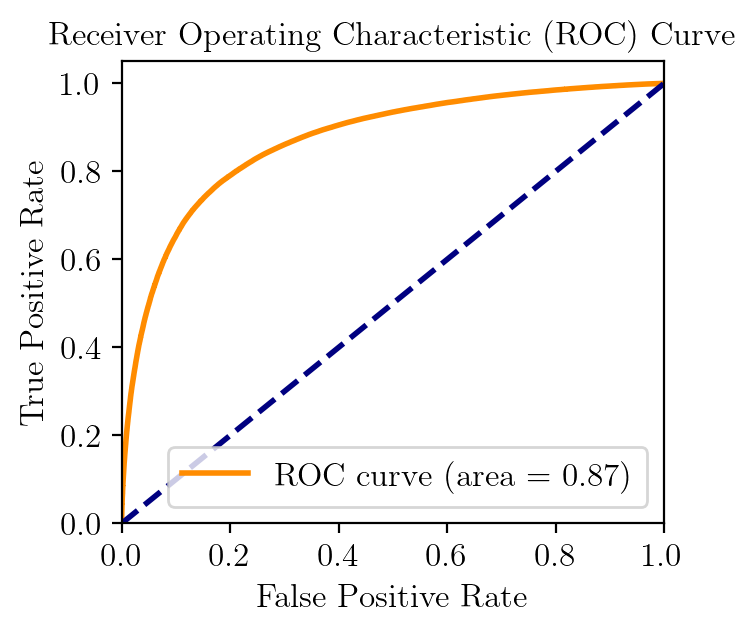

saved


0

In [24]:
model_mlp.load_state_dict(torch.load('saved_ml_models/best_method_model.pth'))
plot_roc(model_mlp, test_dataloader)
compute_roc(model_mlp, test_dataloader, filename="method_final")

In [25]:
model = model_mlp
dataloader = test_dataloader
removal_steps = 95

model.eval()
all_probs = []
all_labels = []

# Get predictions and true labels
with torch.no_grad():
    for inputs, labels,_,_ in dataloader:
        inputs = inputs.to(next(model.parameters()).device)
        outputs = model(inputs.float())
        probs = outputs.cpu().numpy()  # Assuming binary classification
        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# print(all_labels.shape,all_probs.shape)

# Get absolute difference from 0.5 (uncertainty)
uncertainty = np.abs(all_probs - 0.5).flatten()
sorted_indices = np.argsort(uncertainty)

auc_scores = []
percentages_removed = np.linspace(0, 95, removal_steps)

for perc in percentages_removed:
    num_to_remove = int((perc / 100) * len(all_probs))
    
    remaining_indices = sorted_indices[num_to_remove:]
    auc_score = roc_auc_score(all_labels[remaining_indices], all_probs[remaining_indices])

    auc_scores.append(auc_score)


In [26]:
model.eval()  # Set the model to evaluation mode
all_probs = []
all_labels = []

with torch.no_grad():
    for inputs, labels, inx_0, inx_1 in dataloader:
        # Forward pass
        outputs = model(inputs.float())
        # Get probabilities (assuming a binary classification with sigmoid)
        probs = outputs.squeeze().cpu().numpy()
        labels = labels.cpu().numpy()
        
        all_probs.extend(probs)
        all_labels.extend(labels)

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Compute the calibration curve
prob_true, prob_pred = calibration_curve(all_labels, all_probs, n_bins=100)


In [27]:
plt.style.use('tableau-colorblind10')
def plot_style():
    font_size       = 12
    dpi             = 200

    params = {'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "serif",
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
              'text.usetex': True,
             }

    plt.rcParams.update(params)
plot_style()

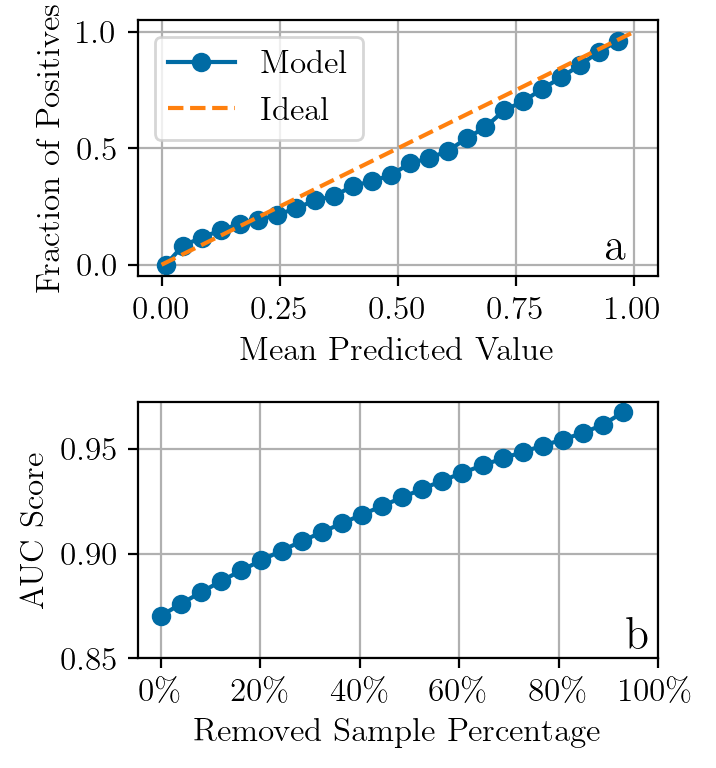

In [28]:
fig,axs = plt.subplots(2,1,figsize=(7.48031/2, 4))

axs[0].plot(prob_pred[::4], prob_true[::4], marker='o', label='Model')
axs[0].plot([0, 1], [0, 1], linestyle='--', label='Ideal')
axs[0].set_xlabel('Mean Predicted Value')
axs[0].set_ylabel('Fraction of Positives')
axs[0].legend(loc='best')
axs[0].grid()

axs[1].plot(percentages_removed[::4], auc_scores[::4], marker='o')
axs[1].set_xlabel('Removed Sample Percentage')
axs[1].set_ylabel('AUC Score')
axs[1].grid(True)

axs[1].set_xticks([0, 20, 40, 60, 80, 100])
axs[1].set_xticklabels([f"{int(p)}\%" for p in [0, 20, 40, 60, 80, 100]])
axs[1].set_yticks([0.85,0.9,0.95])

axs[0].text(0.96, 0.07, 'a',  ha='center', va='center', fontsize=16)
axs[1].text(96, 0.86, 'b',  ha='center', va='center', fontsize=16)

plt.tight_layout()
fig.savefig("figures/callibration_performance.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [ ]:
# # Initial settings for memory map
# initial_size = 1000  # Adjust as needed for small initial size
# growth_factor = 2    # Factor to increase the array each time it fills
# valid_pairs_memmap = np.memmap('valid_pairs.dat', dtype='int32', mode='w+', shape=(initial_size, 2))

# # Initialize batch processing variables
# batch_start = 0

# # Function to expand the memmap file size dynamically
# def expand_memmap(memmap_array, new_size):
#     filename = memmap_array.filename
#     dtype = memmap_array.dtype
#     memmap_array.flush()
#     del memmap_array  # Close the current memory map to avoid conflicts

#     # Resize file on disk
#     with open(filename, 'r+b') as f:
#         f.truncate(new_size * 2 * dtype.itemsize)  # Multiply by 2 for pair structure

#     # Return the resized memmap object
#     return np.memmap(filename, dtype=dtype, mode='r+', shape=(new_size, 2))

# # Populate valid_pairs in chunks
# for sampled_inx_0 in tqdm(range(len(c_inx_arr))):
#     for sampled_inx_1 in range(sampled_inx_0 + 1, len(c_inx_arr)):
#         co_occurrences = word_co_occurrences.get(c_inx_arr[sampled_inx_0], {})
#         if (c_inx_arr[sampled_inx_1] not in co_occurrences or 
#             co_occurrences[c_inx_arr[sampled_inx_1]][0] > 2017):
            
#             # Check if we need to expand the memmap
#             if batch_start >= valid_pairs_memmap.shape[0]:
#                 new_size = valid_pairs_memmap.shape[0] * growth_factor
#                 valid_pairs_memmap = expand_memmap(valid_pairs_memmap, new_size)
            
#             # Write the current valid pair to the memmap
#             valid_pairs_memmap[batch_start] = (sampled_inx_0, sampled_inx_1)
#             batch_start += 1

# # Trim excess space in the final memmap
# valid_pairs_memmap.flush()
# valid_pairs_memmap = np.memmap('valid_pairs.dat', dtype='int32', mode='r+', shape=(batch_start, 2))

# train_window_data = c_encoding_arr[:, -input_window_size-output_window_size-offset_to_current_year:-output_window_size-offset_to_current_year]
# inx_map = {val: idx for idx, val in enumerate(c_inx_arr)}

# # Define final sizes based on the length of `valid_pairs`
# final_size = len(valid_pairs_memmap)

# # Initialize memory-mapped files with the final size
# pred_arr_memmap = np.memmap('pred_arr.dat', dtype='float32', mode='w+', shape=(final_size,))
# inx_pair_arr_memmap = np.memmap('inx_pair_arr.dat', dtype='int32', mode='w+', shape=(final_size, 2))


# # Define the batch size
# batch_size = 100
# batch_start = 0

# # Processing loop for `valid_pairs`
# for i in tqdm(range(0, final_size, batch_size)):
#     batch_pairs = valid_pairs_memmap[i:i + batch_size]
#     encodings = []
#     index_pairs = []

#     # Create encodings and index pairs for the batch
#     for inx_0, inx_1 in batch_pairs:
#         enc_0 = train_window_data[inx_map[c_inx_arr[inx_0]]]
#         enc_1 = train_window_data[inx_map[c_inx_arr[inx_1]]]
#         enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
#         encodings.append(enc_01)
#         index_pairs.append([inx_0, inx_1])

#     # Batch predictions using the model
#     encodings_tensor = torch.from_numpy(np.array(encodings)).float()
#     predictions = model_mlp(encodings_tensor).detach().numpy().flatten()

#     # Write the current batch to the memory-mapped files
#     pred_arr_memmap[batch_start:batch_start + len(predictions)] = predictions
#     inx_pair_arr_memmap[batch_start:batch_start + len(index_pairs)] = index_pairs

#     # Update start position for the next batch
#     batch_start += len(predictions)

# # Final flush to ensure data is saved
# pred_arr_memmap.flush()
# inx_pair_arr_memmap.flush()

# # Assuming pred_arr_memmap is the memory-mapped array containing predictions
# top_n = 300  # Number of top predictions you want

# # Use np.argpartition to efficiently get the top 100 indices
# indices = np.argpartition(pred_arr_memmap, -top_n)[-top_n:]

# # Now, sort the selected indices in descending order to get the top 100 predictions
# sorted_indices = indices[np.argsort(pred_arr_memmap[indices])[::-1]]

# # Retrieve the corresponding prediction values
# top_predictions = pred_arr_memmap[sorted_indices]
# top_concepts = inx_pair_arr_memmap[sorted_indices]

# for _pred, _inx in zip(top_predictions,top_concepts):
#     in_0,in_1 = _inx
#     try:
#         years = word_co_occurrences[c_inx_arr[in_0]][c_inx_arr[in_1]][0]
#         if years > 2020:
#             print(years,c_inx_arr[in_0],c_inx_arr[in_1],_pred)
#     except:
#         print("-",c_inx_arr[in_0],c_inx_arr[in_1],_pred)



100%|██████████| 10235/10235 [02:21<00:00, 72.14it/s]


In [ ]:
# quantum_technology cluster_state_generation 7627 994 2023
# optical_setup quantum_violation 5575 7674 2022
# machine_learning_algorithm quantum_phase_transition 4504 7421 2021
# tensor_network local_quantum_circuit 9452 4380 2023

# concept_plot_arr = [["quantum technology", "cluster state generation"],["optical setup", "quantum violation"],["machine learning algorithm" ,"quantum phase transition"],["tensor network" ,"local quantum circuit"]]
# sampled_pair_arr = [[7627,994],[5575,7674],[4504,7421],[9452,4380]]
# marker_arr = [2023,2022,2021,2023]

# 4503 7766 machine_learning qubit_mapping 2023 0.98830706

# 6905 56 quantum_computing active_space 2019
# 9452,4380 tensor network local quantum circuit 2023
# 4503 5675 machine_learning optimized_circuit 2020 0.9840036

concept_plot_arr = [["quantum computing", "active space"],["machine learning", "optimized circuit"],["tensor network" ,"local quantum circuit"]]
sampled_pair_arr = [[6905,56],[4503, 5675],[9452,4380]]
marker_arr = [2019,2020, 2023]

offset = 7 
year_arr_plot_subset = np.unique(year_arr)[offset:]
pred_arr = np.zeros((3,len(year_arr_plot_subset)))
for c1,sampled_pair in enumerate(sampled_pair_arr):
    for c2,i in enumerate(range(len(np.unique(year_arr_plot_subset)))):
        train_window_data = c_encoding_arr[:, offset+i:offset+i+1]

        inx_0 = np.where(c_inx_arr == c_inx_arr[sampled_pair[0]])[0]
        inx_1 = np.where(c_inx_arr == c_inx_arr[sampled_pair[1]])[0]

        enc_0 = train_window_data[inx_0][0]
        enc_1 = train_window_data[inx_1][0]
        enc_01 = np.concatenate((enc_0, enc_1), axis=-1)
        
        pred_arr[c1,c2] = model_mlp(torch.from_numpy(enc_01).float()).detach().numpy()[0][0]

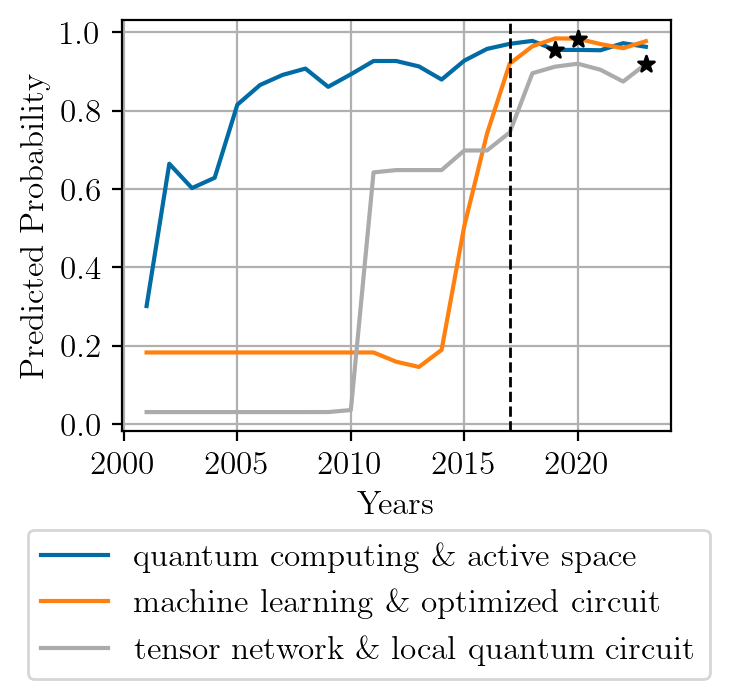

In [ ]:
fig, axs = plt.subplots(1,figsize=(3.54331, 3.54331))

for c1, plot_pred_arr in enumerate(pred_arr):
    # Plot line and scatter together with the same label
    axs.plot(year_arr_plot_subset, plot_pred_arr, label=f"{concept_plot_arr[c1][0]} \& {concept_plot_arr[c1][1]}")
    axs.scatter(marker_arr[c1], plot_pred_arr[np.where(year_arr_plot_subset == marker_arr[c1])],marker='*',zorder=10,c="black")

# Add a legend below the plot
axs.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2), ncol=1)
axs.axvline(x=2017, color='black', linestyle='--', linewidth=1)
# Labeling and grid
axs.set_ylabel('Predicted Probability')
axs.set_xlabel('Years')
axs.grid(True)

# Adjust layout to make space for the legend below the plot within the same figure size
fig.subplots_adjust(bottom=0.3)  # Adjust this value to fine-tune legend placement
fig.savefig("figures/3_predictions.pdf", format="pdf", bbox_inches="tight")
plt.show()